Using TensorFlow backend.


STOCK #0 Test mae: 3.137 Percentage mae: 15.2233


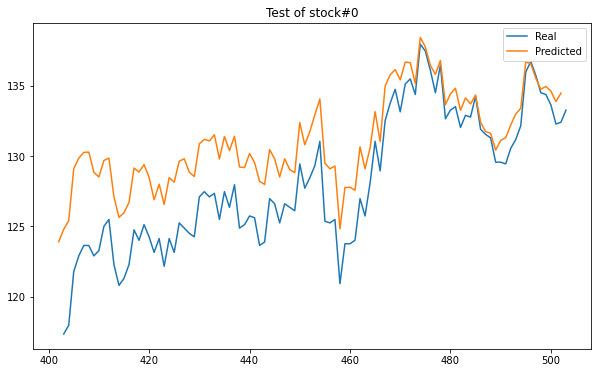

STOCK #1 Test mae: 1.5118 Percentage mae: 72.3561


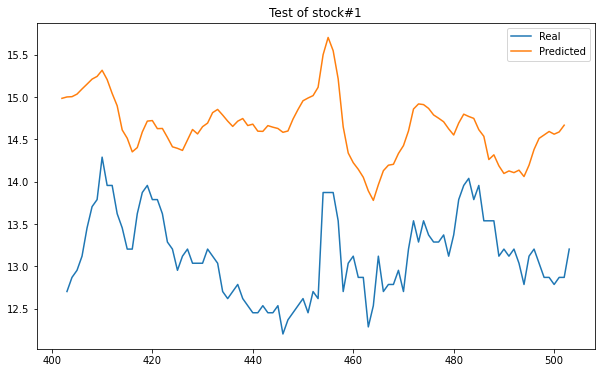

STOCK #2 Test mae: 1.3254 Percentage mae: 32.5594


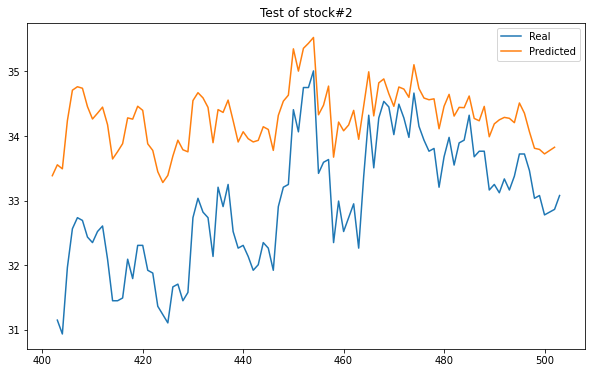

STOCK #3 Test mae: 4.2443 Percentage mae: 27.1273


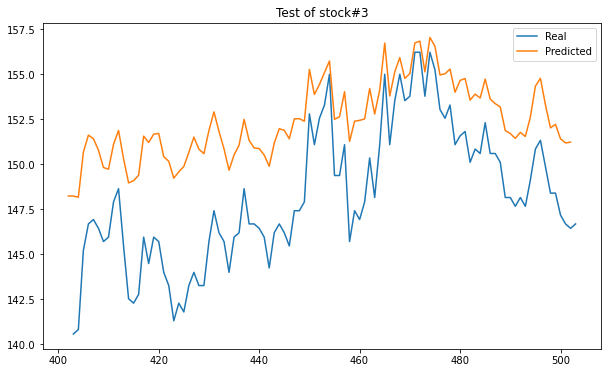

STOCK #4 Test mae: 0.458 Percentage mae: 25.7594


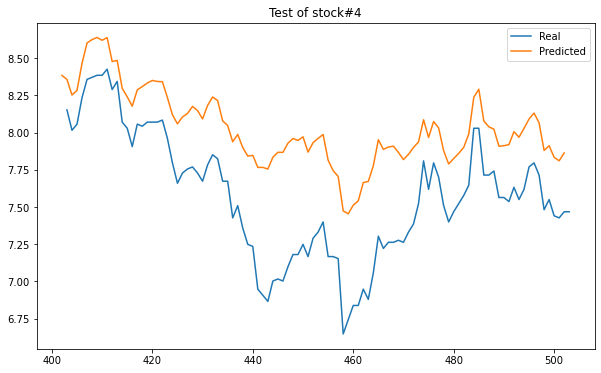

STOCK #5 Test mae: 0.4174 Percentage mae: 10.8599


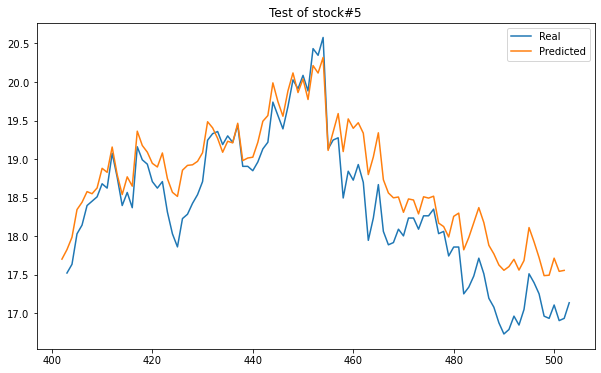

STOCK #6 Test mae: 3.2584 Percentage mae: 18.6916


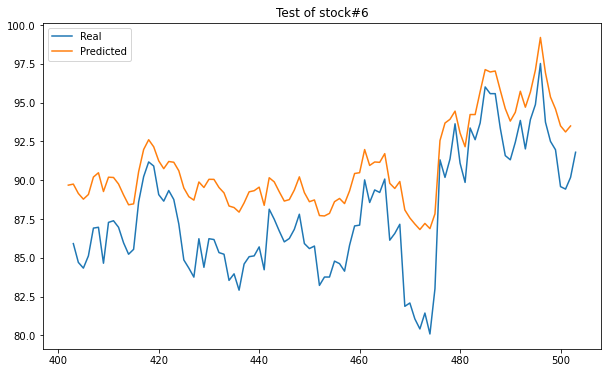

STOCK #7 Test mae: 2.1786 Percentage mae: 8.44


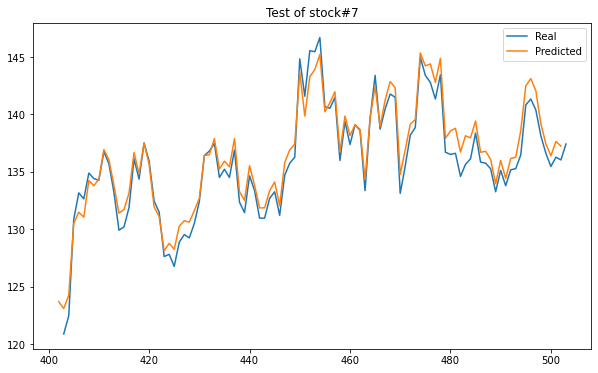

STOCK #8 Test mae: 6.6476 Percentage mae: 11.2093


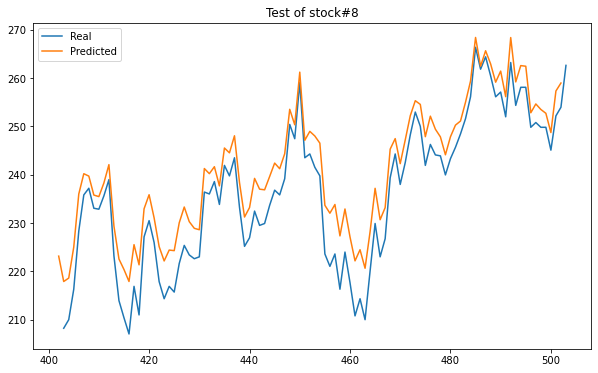

STOCK #9 Test mae: 0.1784 Percentage mae: 12.6773


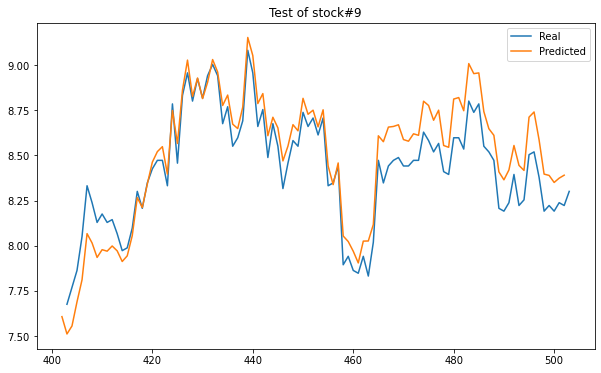

STOCK #10 Test mae: 7.4858 Percentage mae: 22.7319


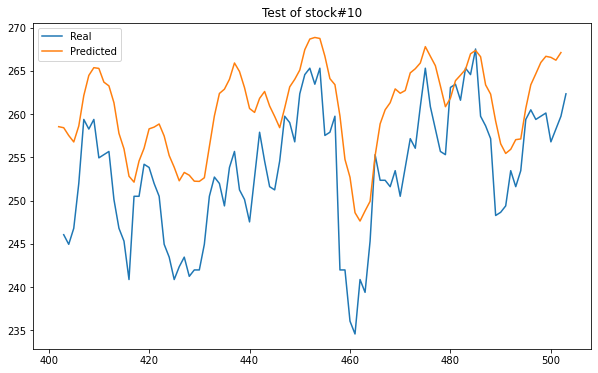

STOCK #11 Test mae: 7.9818 Percentage mae: 10.0987


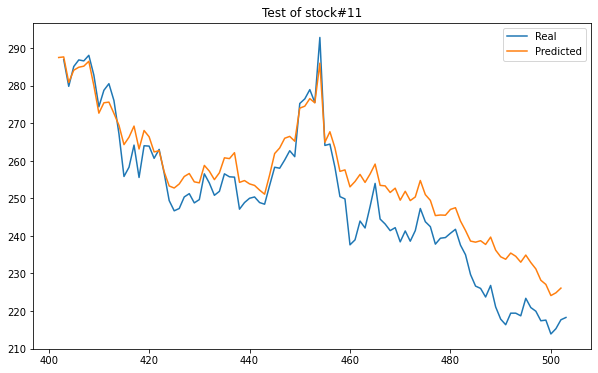

STOCK #12 Test mae: 4.6764 Percentage mae: 21.9738


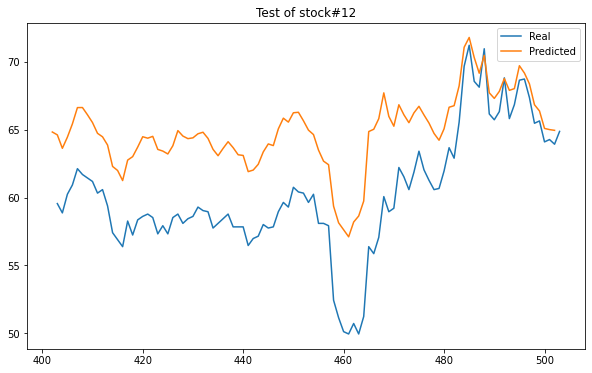

STOCK #13 Test mae: 16.6297 Percentage mae: 39.8994


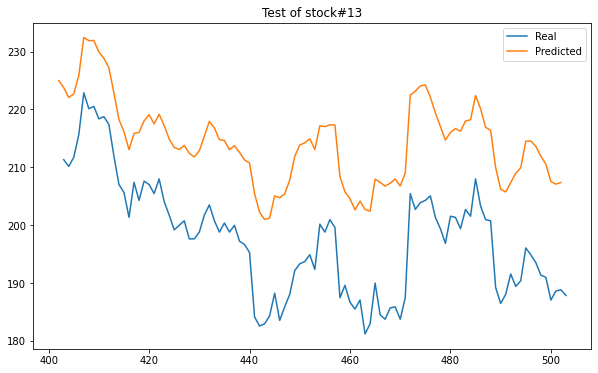

STOCK #14 Test mae: 14.5911 Percentage mae: 112.3017


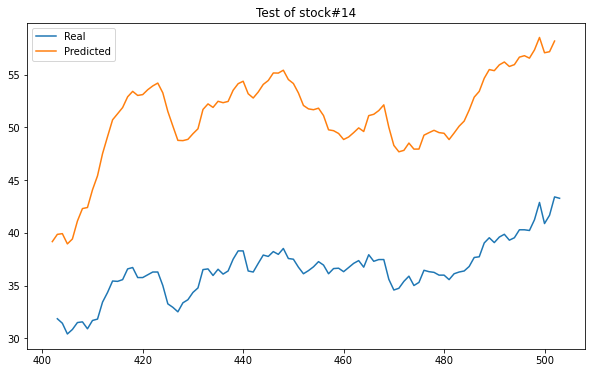

STOCK #15 Test mae: 3.9008 Percentage mae: 6.8771


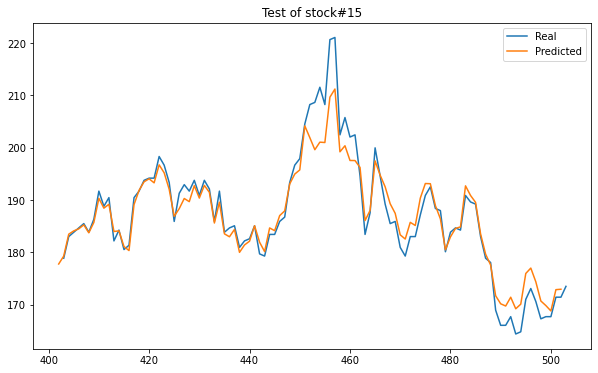

STOCK #16 Test mae: 7.5385 Percentage mae: 7.1113


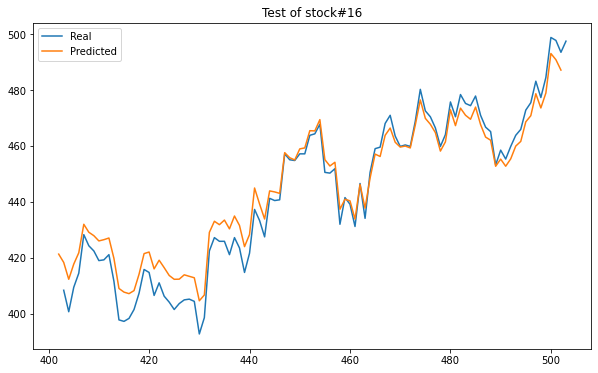

STOCK #17 Test mae: 90.6746 Percentage mae: 16.4729


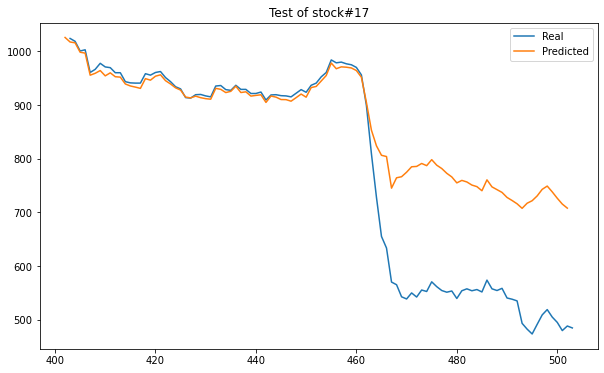

STOCK #18 Test mae: 126.7853 Percentage mae: 8.3614


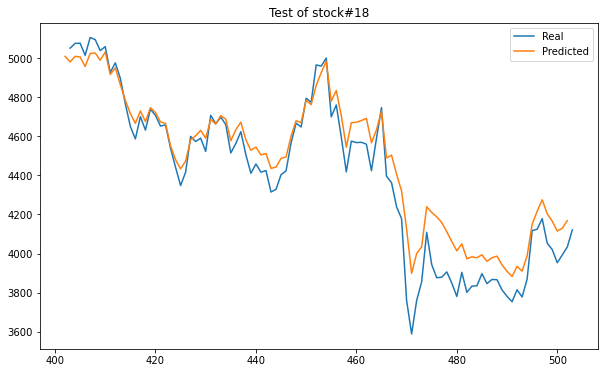

STOCK #19 Test mae: 3.3806 Percentage mae: 9.1099


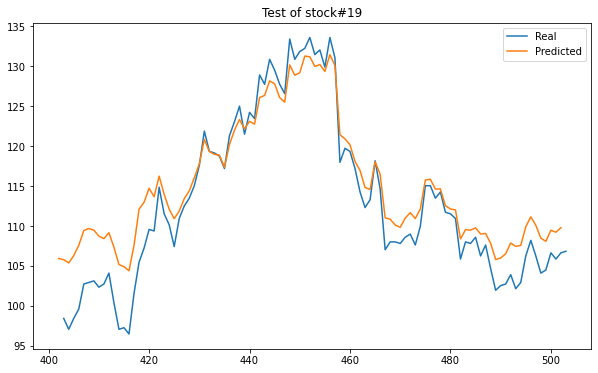

STOCK #20 Test mae: 4.2048 Percentage mae: 11.3049


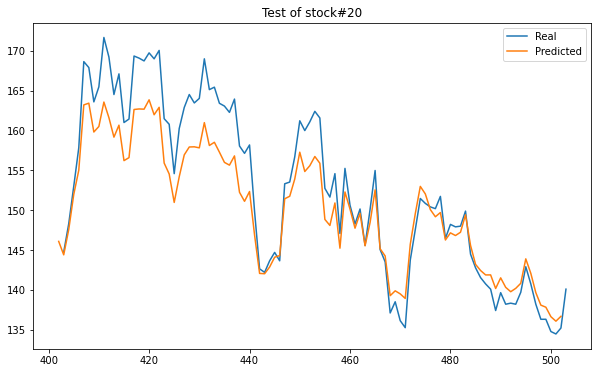

STOCK #21 Test mae: 8.1644 Percentage mae: 64.9826


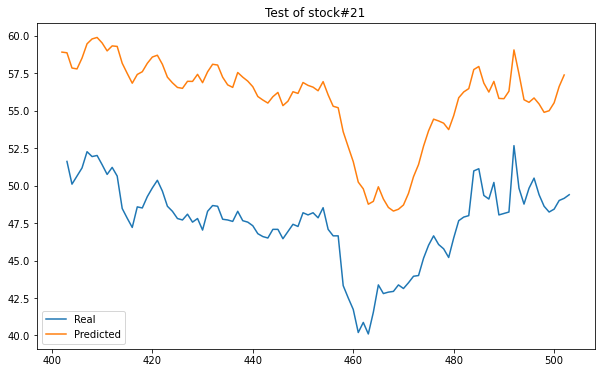

STOCK #22 Test mae: 13.8768 Percentage mae: 5.4627


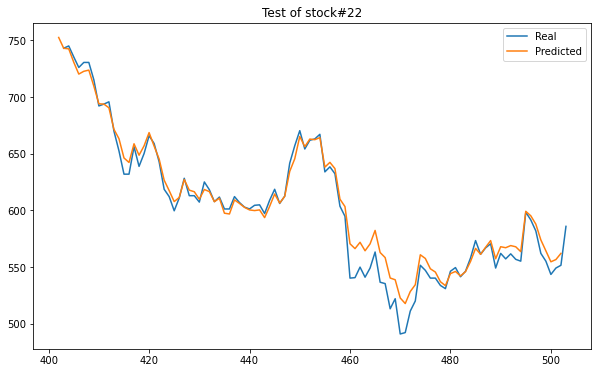

STOCK #23 Test mae: 41.0629 Percentage mae: 74.2921


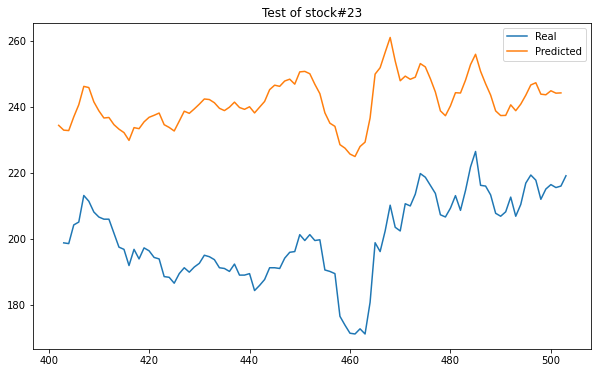

STOCK #24 Test mae: 46.2304 Percentage mae: 8.1535


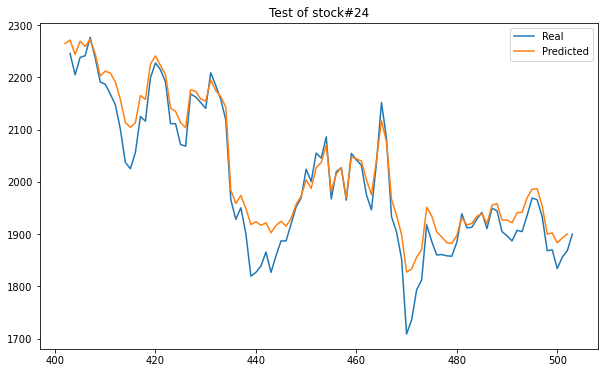

STOCK #25 Test mae: 1.8577 Percentage mae: 16.8569


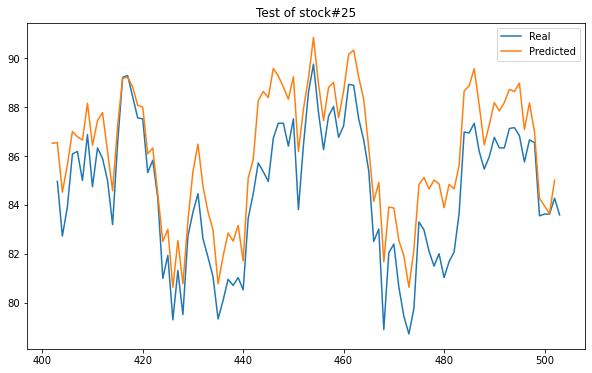

STOCK #26 Test mae: 0.9663 Percentage mae: 34.4078


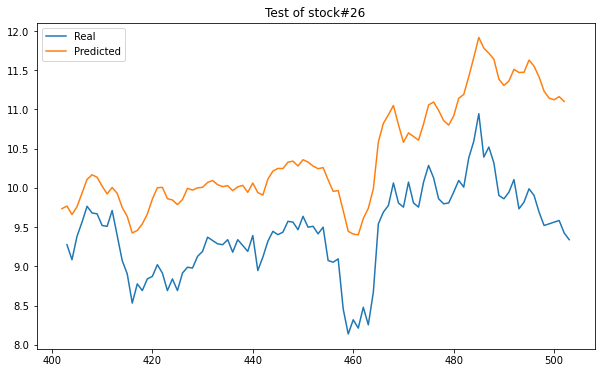

STOCK #27 Test mae: 2.4254 Percentage mae: 43.6104


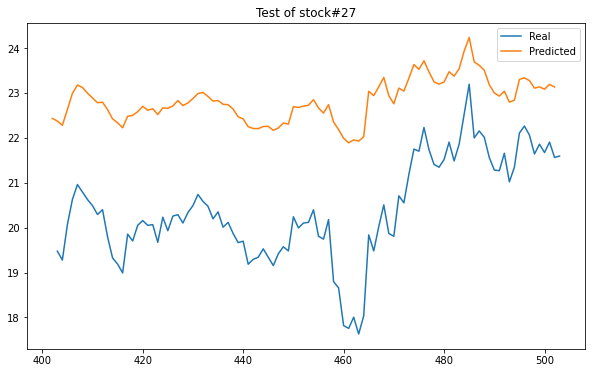

STOCK #28 Test mae: 0.1748 Percentage mae: 6.7984


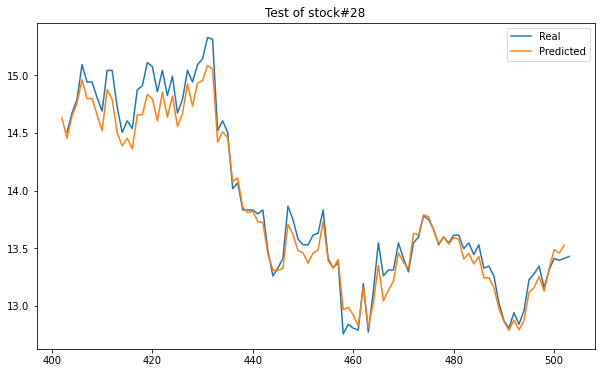

STOCK #29 Test mae: 0.7579 Percentage mae: 12.2304


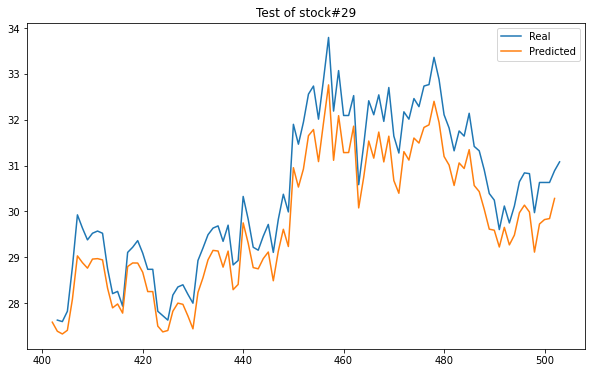

STOCK #30 Test mae: 0.6661 Percentage mae: 7.4556


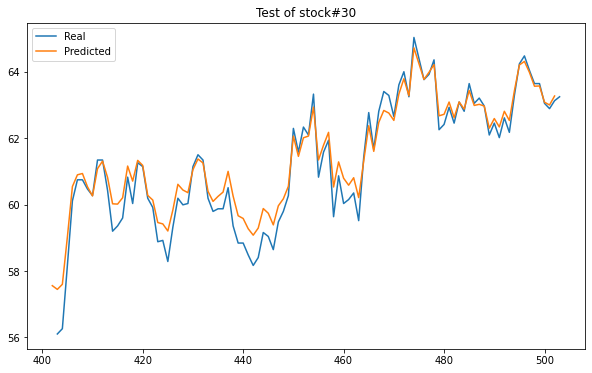

STOCK #31 Test mae: 1.104 Percentage mae: 64.1888


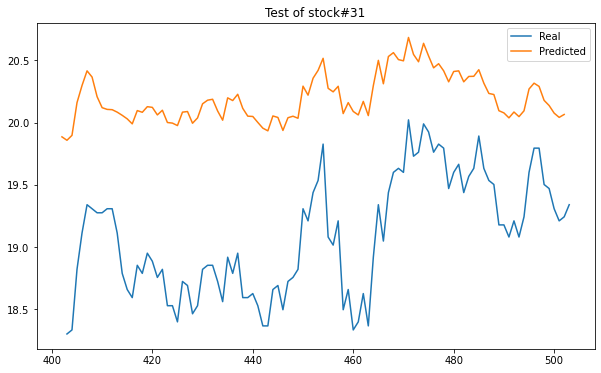

STOCK #32 Test mae: 0.8853 Percentage mae: 19.1732


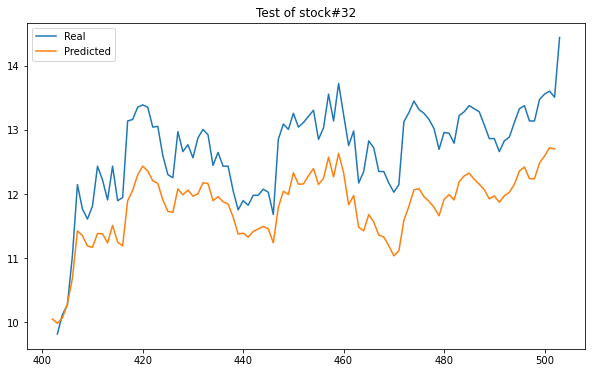

STOCK #33 Test mae: 0.0595 Percentage mae: 7.1172


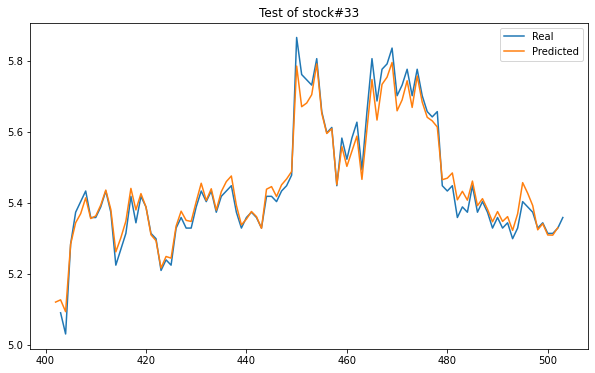

STOCK #34 Test mae: 2.3822 Percentage mae: 8.1188


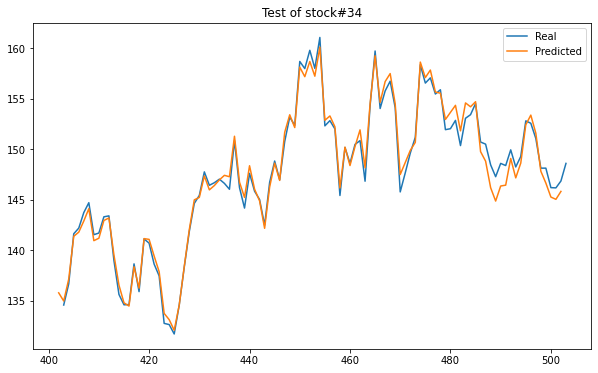

STOCK #35 Test mae: 0.1185 Percentage mae: 11.6591


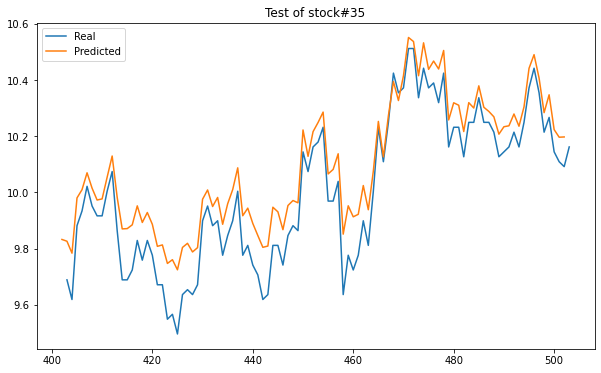

STOCK #36 Test mae: 0.7512 Percentage mae: 70.1563


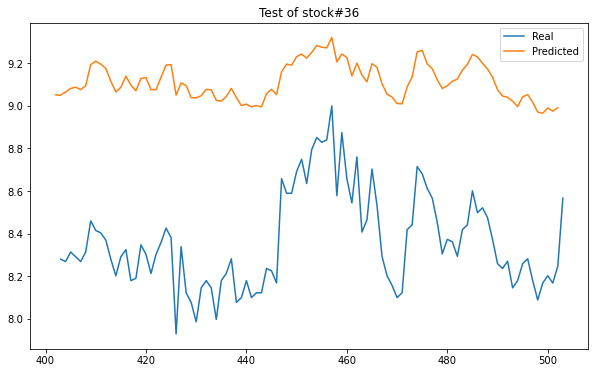

STOCK #37 Test mae: 0.1007 Percentage mae: 9.8356


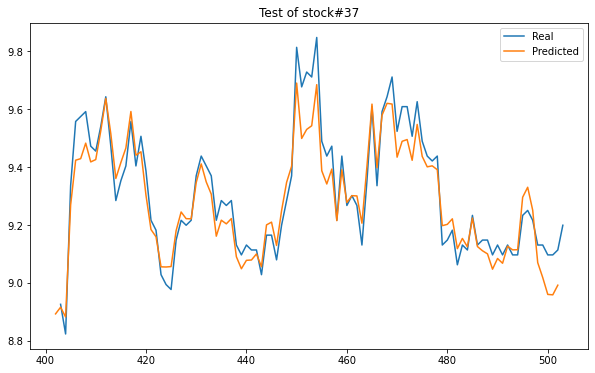

STOCK #38 Test mae: 0.7926 Percentage mae: 8.705


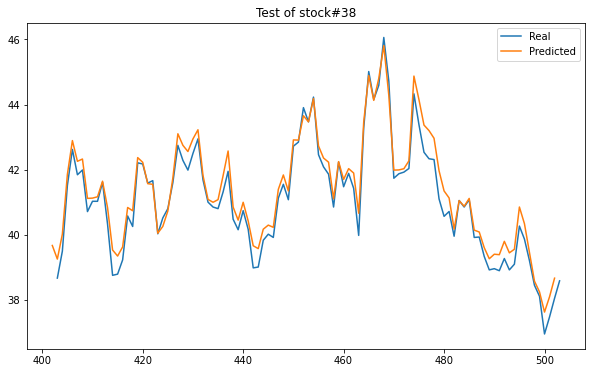

STOCK #39 Test mae: 0.7815 Percentage mae: 21.5585


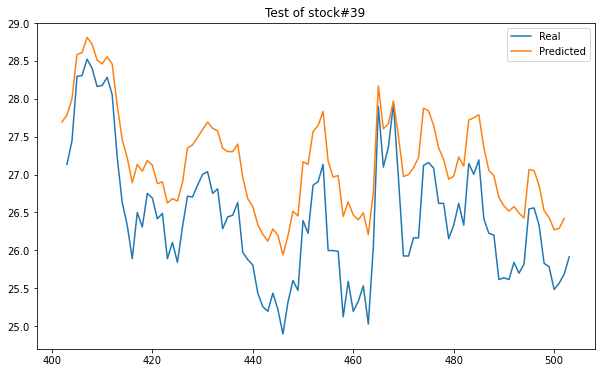

STOCK #40 Test mae: 0.2243 Percentage mae: 10.4399


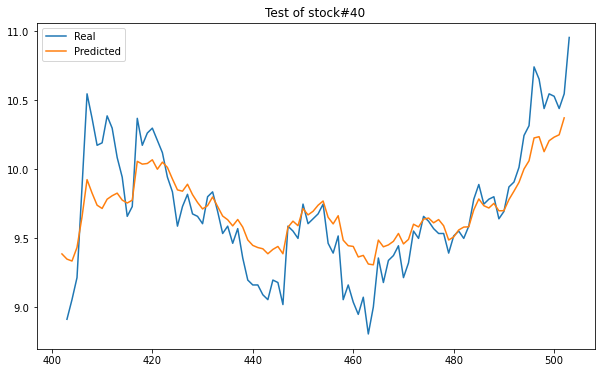

STOCK #41 Test mae: 0.8134 Percentage mae: 15.9082


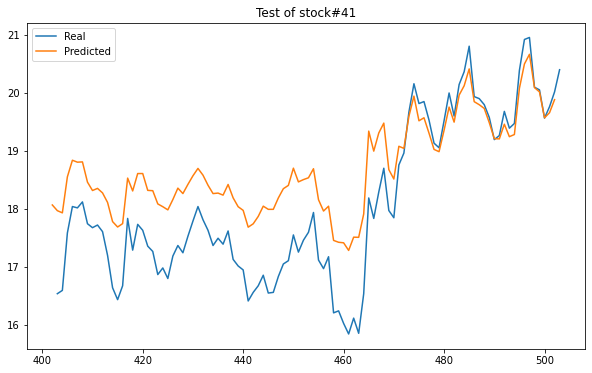

STOCK #42 Test mae: 0.8073 Percentage mae: 29.0682


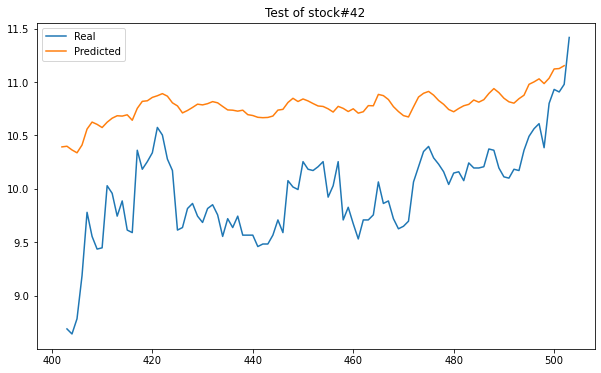

STOCK #43 Test mae: 0.4214 Percentage mae: 10.6618


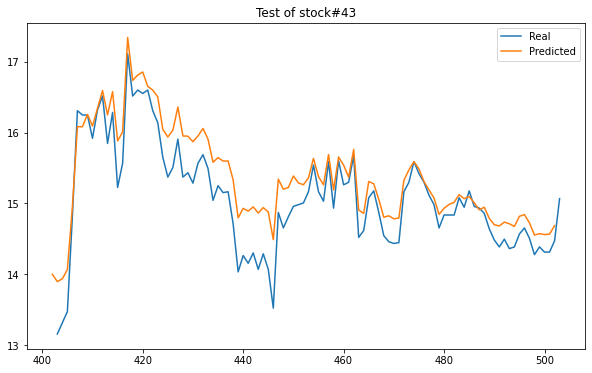

STOCK #44 Test mae: 0.0675 Percentage mae: 7.7724


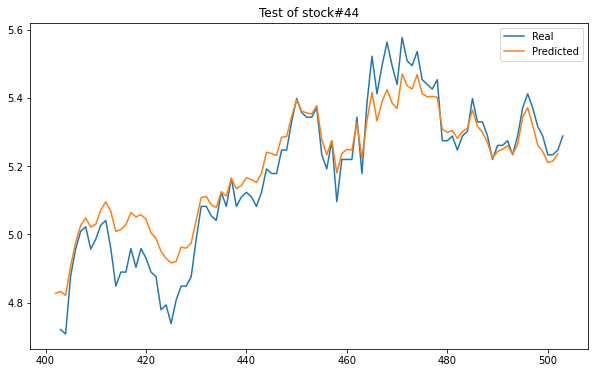

STOCK #45 Test mae: 0.1617 Percentage mae: 5.7137


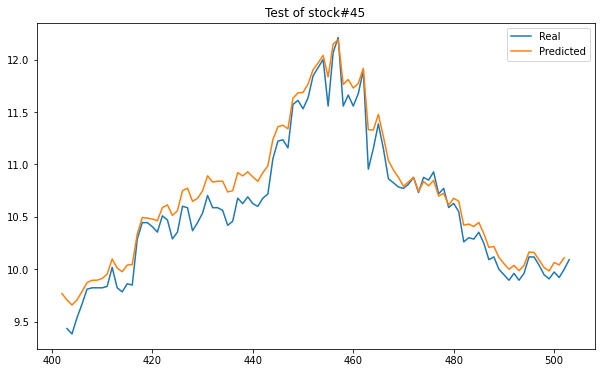

STOCK #46 Test mae: 0.1553 Percentage mae: 6.2665


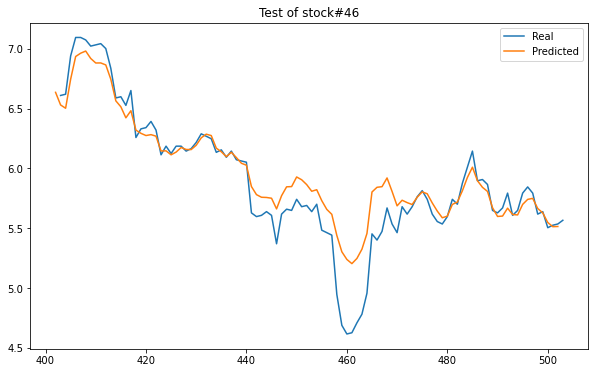

STOCK #47 Test mae: 0.0503 Percentage mae: 10.0599


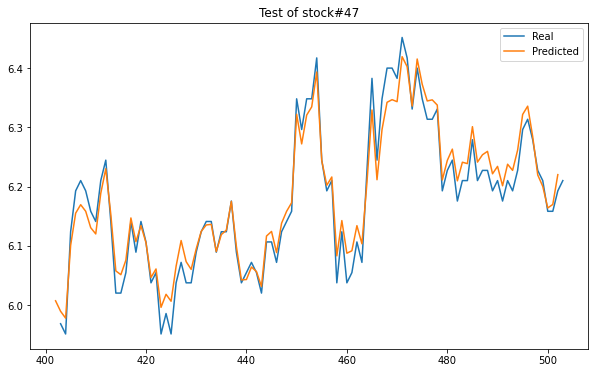

STOCK #48 Test mae: 1.3489 Percentage mae: 200.0684


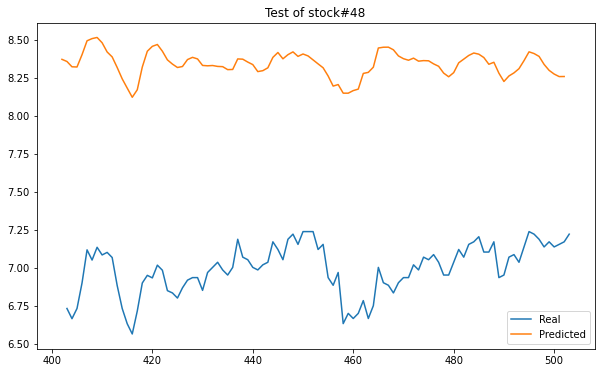

STOCK #49 Test mae: 0.1532 Percentage mae: 15.0115


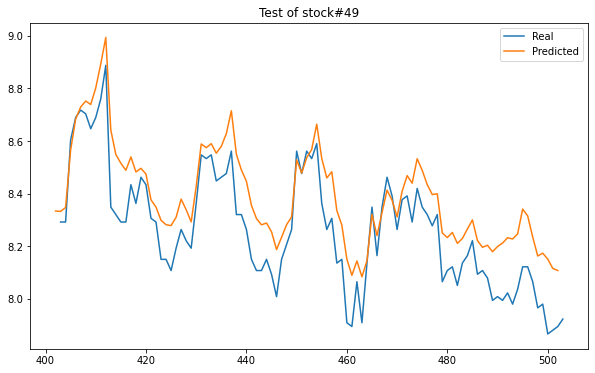

In [1]:
from os import listdir
from os.path import isfile, join

import os
import pandas as pd

from sklearn import preprocessing
import numpy as np

import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers

import matplotlib.pyplot as plt


# Set paths
p = os.path.abspath('..')
p1 = p + '\\raw data 17-19\\'
p2 = p + '\\engineered features 17-19\\'

# Get all file names.csv
onlyfiles = [f for f in listdir(p1) if isfile(join(p1, f))]

for f, stock_num in zip(onlyfiles[0:50], range(50)):
    
    # Read file
    raw_df = pd.read_csv(p1+f)
    tech_df = pd.read_csv(p2+f)
    raw_df = raw_df.drop('Time', axis=1)
    # raw_df = raw_df.drop('Volume', axis=1)
    tech_df = tech_df.drop('Unnamed: 0', axis=1)
    
    tech_df.index = tech_df.index+15
    tech_df = tech_df.reindex(np.arange(740+15))
    
    raw_df = pd.concat([raw_df, tech_df], axis = 1)
    raw_df = raw_df.drop('MA15lag', axis=1)
    raw_df = raw_df.drop('day15Returnlag', axis=1)
    

    # Parameters
    history_points = 15
    tech_elim_days = 16
    model_unseen_split_point = 504
    train_test_split_ratio = 0.8

    # Split data
    raw_df_model = raw_df[0:model_unseen_split_point]  # Size of 504
    raw_df_unseen = raw_df[model_unseen_split_point:756] # Size of 756-504

    train_test_split_point = int(raw_df_model.shape[0] * train_test_split_ratio) # 403
    raw_df_model_train = raw_df_model[:train_test_split_point] # Size of 504*0.8
    raw_df_model_test = raw_df_model[train_test_split_point:] # Size of 504*0.2



    # Normalize
    data_normaliser = preprocessing.MinMaxScaler().fit(raw_df_model_train) # Use training data to fit normaliser

    data_normalised = data_normaliser.transform(raw_df)
    model_normalised = data_normaliser.transform(raw_df_model)  # Size = 504
    unseen_normalised = data_normaliser.transform(raw_df_unseen)  # Size = 756-504, unseen, only for final evaluation



    # TOMORROW
    # X, Y for train and test (Model use)
    x_train_normalised = np.array([model_normalised[i  : i + history_points].copy() \
                                          for i in range(tech_elim_days, len(raw_df_model_train) - history_points)])
    y_train_normalised = np.array([model_normalised[:,3][i + history_points].copy() \
                                          for i in range(tech_elim_days, len(raw_df_model_train) - history_points)])
    y_train_normalised = np.expand_dims(y_train_normalised, -1)

    x_test_normalised = np.array([model_normalised[i  : i + history_points].copy() \
                        for i in range(tech_elim_days + x_train_normalised.shape[0], len(raw_df_model) - history_points)])
    y_test_normalised = np.array([model_normalised[:,3][i + history_points].copy() \
                        for i in range(tech_elim_days + x_train_normalised.shape[0], len(raw_df_model) - history_points)])
    y_test_normalised = np.expand_dims(y_test_normalised, -1)

    unseen_x_normalised = np.array([data_normalised[i  : i + history_points].copy() \
                          for i in range(model_unseen_split_point - history_points, len(data_normalised) - history_points)])
    unseen_y_normalised = np.array([data_normalised[:,3][i + history_points].copy() \
                          for i in range(model_unseen_split_point - history_points, len(data_normalised) - history_points)])
    unseen_y_normalised = np.expand_dims(unseen_y_normalised, -1)

    # Unormalised data
    y_test_unscale = np.array([np.array(raw_df_model)[:,3][i + history_points].copy() \
                        for i in range(tech_elim_days + x_train_normalised.shape[0], len(raw_df_model) - history_points)])
    y_test_unscale = np.expand_dims(y_test_unscale, -1)
    unseen_y_unscale = np.array([np.array(raw_df)[:,3][i + history_points].copy() \
                          for i in range(model_unseen_split_point - history_points, len(data_normalised) - history_points)])
    unseen_y_unscale = np.expand_dims(unseen_y_unscale, -1)
    
    y_normaliser = preprocessing.MinMaxScaler()
    y_normaliser.fit(np.expand_dims(raw_df_model_train.loc[:, 'Close'].values, -1))



    # Setting Seeds
    np.random.seed(4)
    tf.random.set_seed(4)

    # Model Structures
    lstm_input = keras.layers.Input(shape=(history_points, len(raw_df.columns)), name='lstm_input')
    x = LSTM(50, name='lstm_0')(lstm_input)
    x = Dropout(0.2, name='lstm_dropout_0')(x)
    x = Dense(64, name='dense_0')(x)
    x = Activation('sigmoid', name='sigmoid_0')(x)
    x = Dense(1, name='dense_1')(x)
    output = Activation('linear', name='linear_output')(x)

    # for tomorrow
    model = Model(inputs=lstm_input, outputs=output)
    adam = optimizers.Adam(lr=0.0005)
    model.compile(optimizer=adam, loss='mae')



    # Train the model
    hist = model.fit(x=x_train_normalised, y=y_train_normalised, 
              batch_size=32, epochs=300, verbose=0, shuffle=True, validation_split=0.1)
#     evaluation = model.evaluate(x_test_normalised, y_test_normalised)
#     print(evaluation)



    # Predict on tomorrow test set
#     y_test_predicted = model.predict(x_test_normalised)

#     y_test_predicted_temp = []
#     temp = []
#     for i in range(len(y_test_predicted)):
#         y_test_predicted_temp.append([0, 0, y_test_predicted[i][0], 0, 0])

#     y_test_predicted_temp = np.array(y_test_predicted_temp)
#     y_test_predicted_temp = data_normaliser.inverse_transform(y_test_predicted_temp)

#     for i in range(len(y_test_predicted)):
#         y_test_predicted[i][0] = y_test_predicted_temp[i][2]
    y_test_predicted = model.predict(x_test_normalised)
    y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

    # Calculate the MAE
    real_mse = np.mean(abs(y_test_unscale - y_test_predicted))
    scaled_mse = real_mse / np.meam(y_test_unscale) * 100
    print(f'STOCK #{stock_num} Test mae: {round(real_mse, 4)} Percentage mae: {round(scaled_mse, 4)}')



    # Draw on test data
    plt.gcf().set_size_inches(10, 6, forward=True)

    start = 0
    end = -1

    real = plt.plot(np.arange(train_test_split_point, model_unseen_split_point, 1), y_test_unscale, label='real')
    pred = plt.plot(np.arange(train_test_split_point-1, model_unseen_split_point-1, 1), 
                    y_test_predicted, label='predicted tomo')

    plt.legend(['Real', 'Predicted'])
    plt.title(f'Test of stock#{stock_num}')
    plt.show()
    continue

                    


# # Predict on tomorrow unseen set
# y_unseen_predicted = model.predict(unseen_x_normalised)

# y_unseen_predicted_temp = []
# temp = []
# for i in range(len(y_unseen_predicted)):
#     y_unseen_predicted_temp.append([0, 0, y_unseen_predicted[i][0], 0])
# y_unseen_predicted_temp = np.array(y_unseen_predicted_temp)
# y_unseen_predicted_temp = data_normaliser.inverse_transform(y_unseen_predicted_temp)
# for i in range(len(y_unseen_predicted)):
#     y_unseen_predicted[i][0] = y_unseen_predicted_temp[i][2]



# # Draw on unseen data
# import matplotlib.pyplot as plt
# plt.gcf().set_size_inches(12, 8, forward=True)

# start = 0
# end = -1

# real = plt.plot(np.arange(model_unseen_split_point, 756, 1), unseen_y_unscale, label='real')
# pred = plt.plot(np.arange(model_unseen_split_point-1, 756-1, 1), y_unseen_predicted, label='predicted')

# plt.legend(['Real', 'Predicted'])
# plt.title(f'Unseen of stock#{stock_num}')
# plt.show()
    